## Fake NEWS classification using Glove | Incomplete

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.utils import pad_sequences

In [4]:
## Importing Dataset
true = pd.read_csv("./True.csv")
false = pd.read_csv("./Fake.csv")

In [8]:
true.head(3)


title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017

In [9]:
false.head(3)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017

In [10]:
true['category'] = 1
false['category'] = 0

In [11]:
df = pd.concat([true,false]) #Merging the 2 datasets

In [14]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

In [16]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [17]:
df

text  category
0      WASHINGTON (Reuters) - The head of a conservat...         1
1      WASHINGTON (Reuters) - Transgender people will...         1
2      WASHINGTON (Reuters) - The special counsel inv...         1
3      WASHINGTON (Reuters) - Trump campaign adviser ...         1
4      SEATTLE/WASHINGTON (Reuters) - President Donal...         1
...                                                  ...       ...
23476  21st Century Wire says As 21WIRE reported earl...         0
23477  21st Century Wire says It s a familiar theme. ...         0
23478  Patrick Henningsen  21st Century WireRemember ...         0
23479  21st Century Wire says Al Jazeera America will...         0
23480  21st Century Wire says As 21WIRE predicted in ...         0

[44898 rows x 2 columns]

## Preprocessing

In [18]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

### Word Cloud for real news

In [19]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

### Word Cloud for fake news

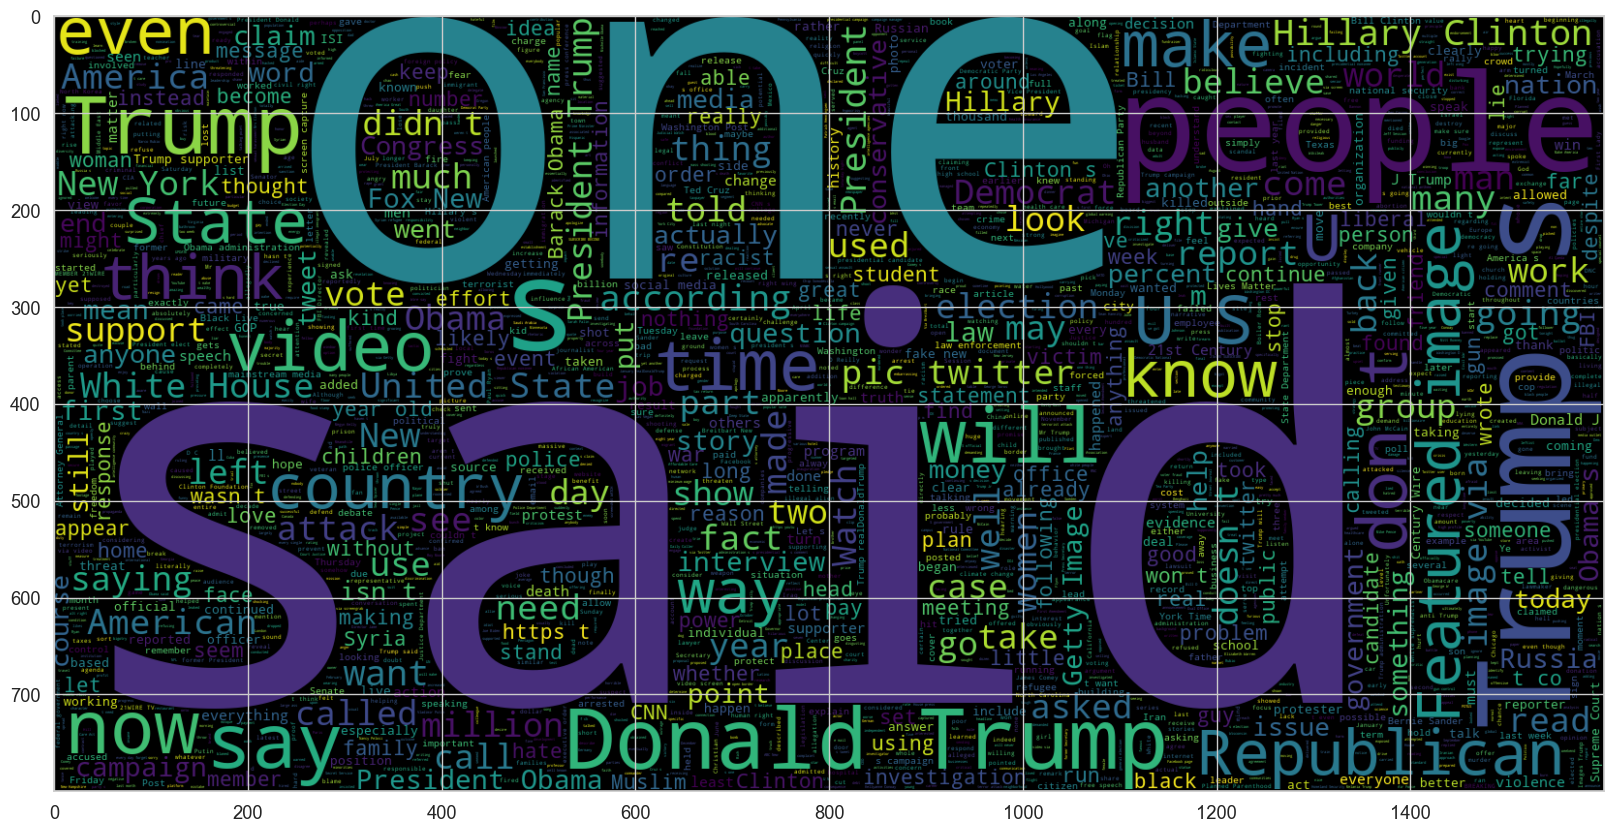

In [20]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

### Number of characters

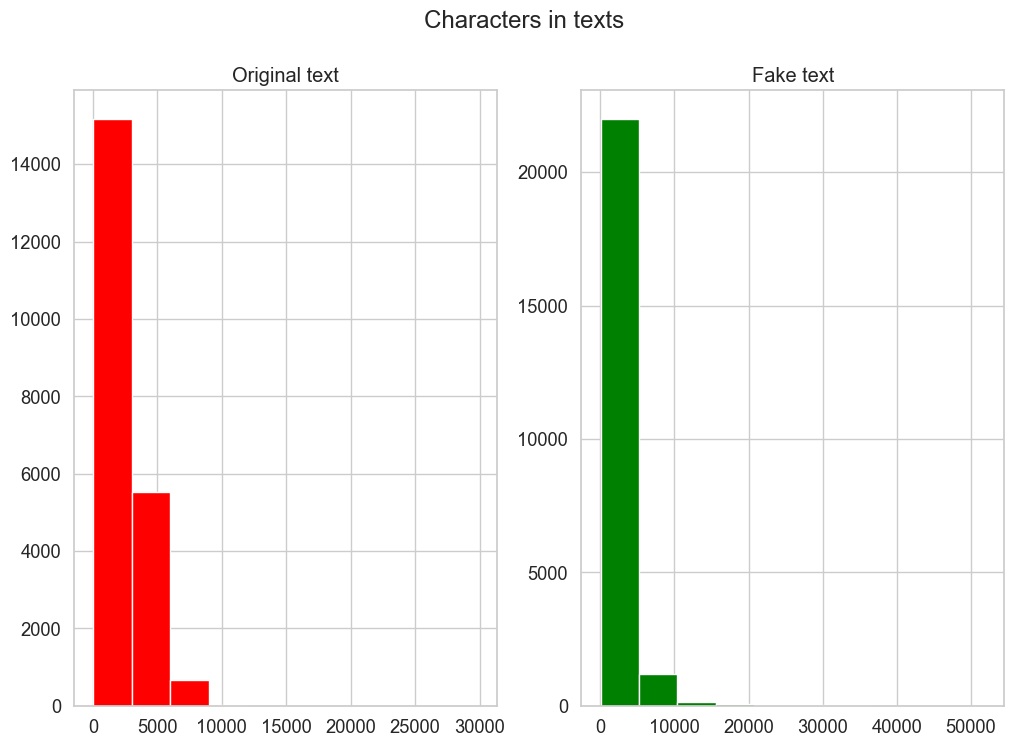

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

### Unigram/Bi Gram/Tri Gram Analysis

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

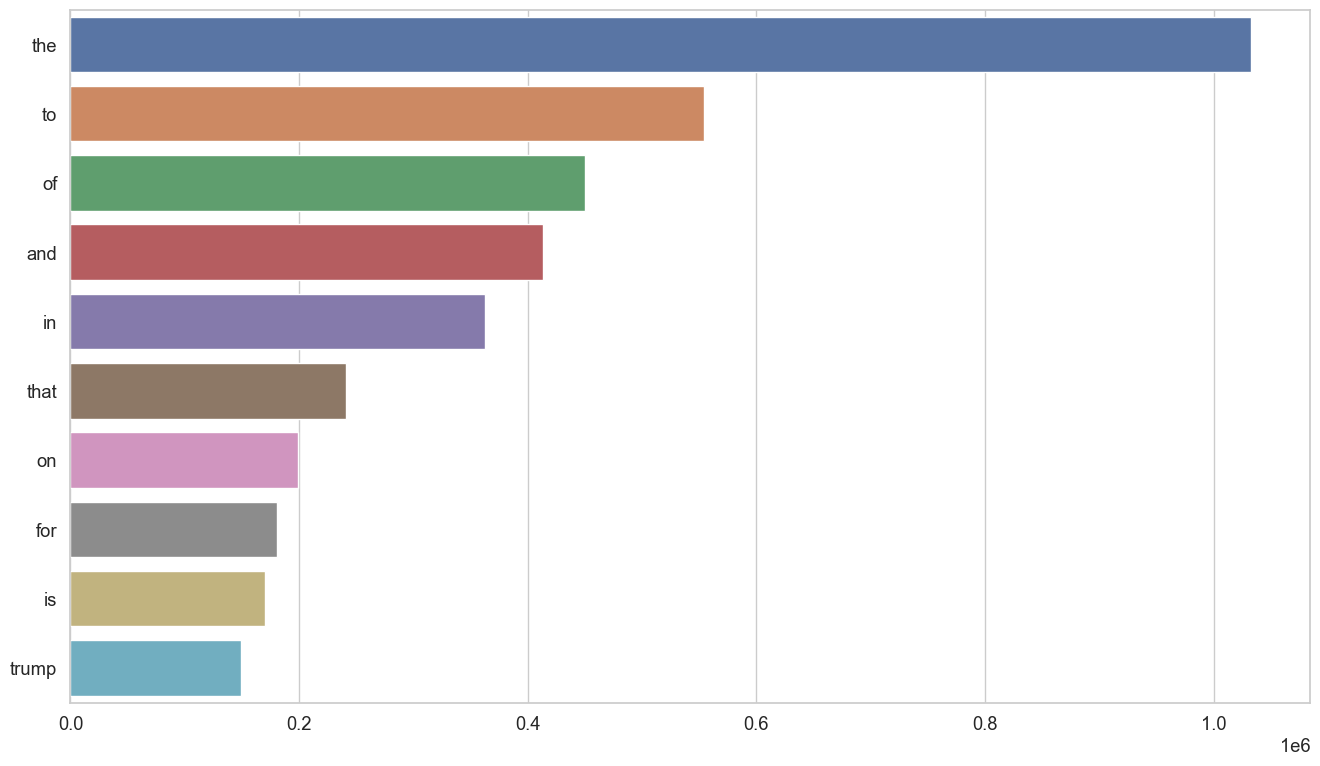

In [24]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

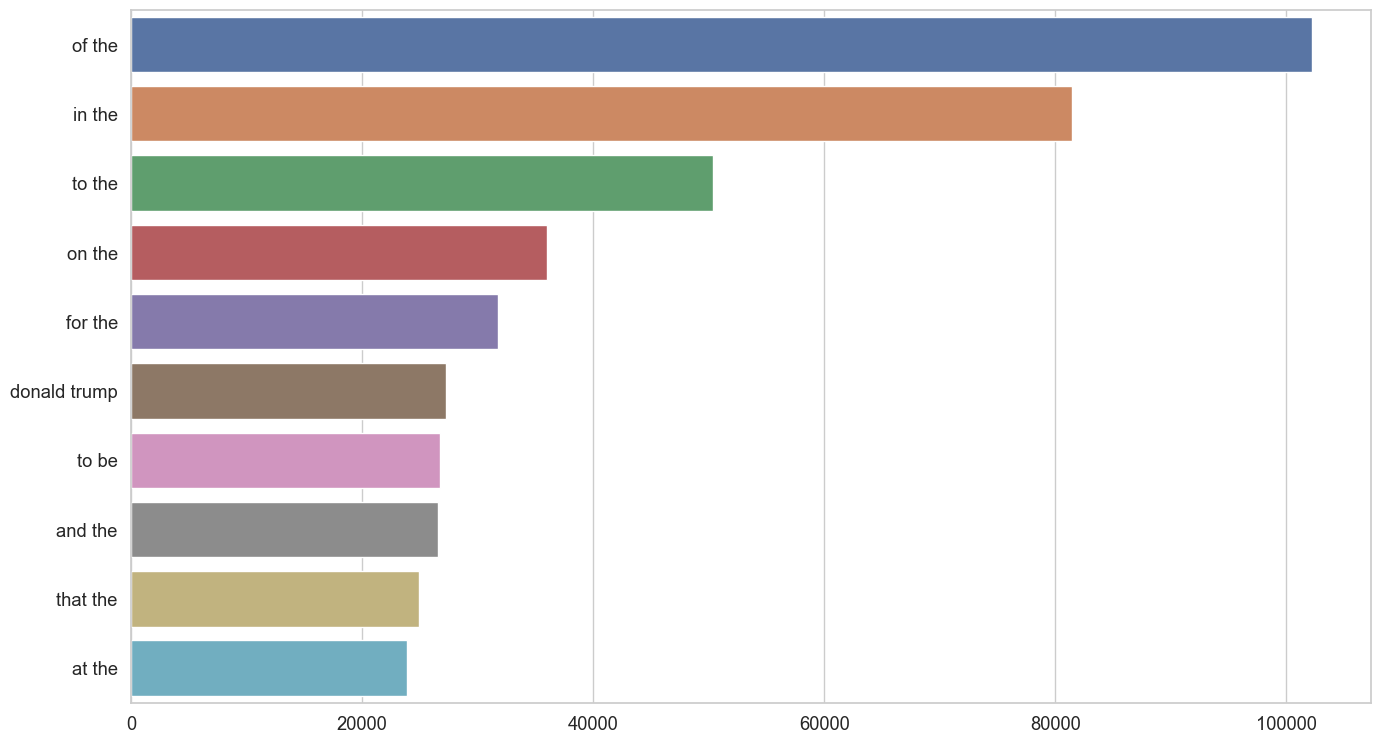

In [25]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

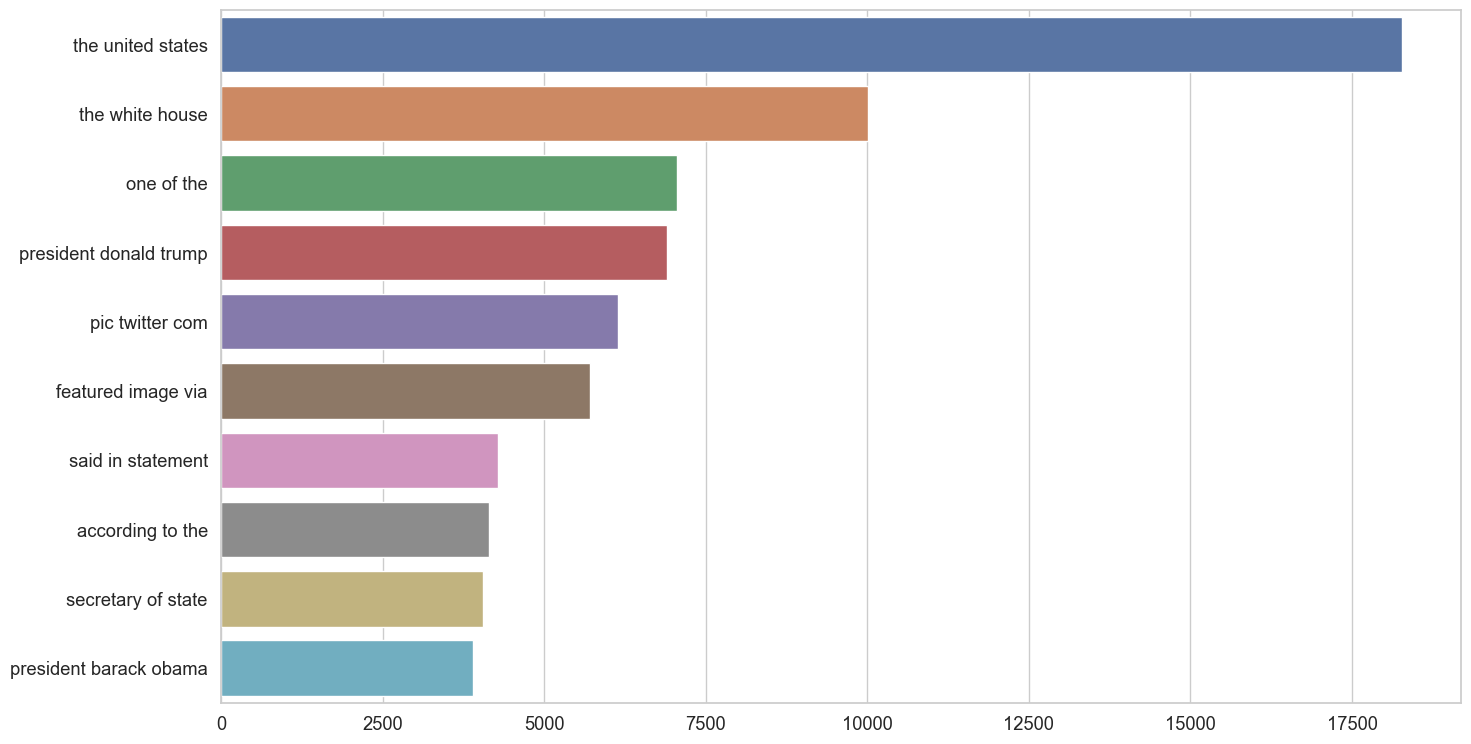

In [26]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

In [28]:
df.head(5)

text  category
0  WASHINGTON (Reuters) - The head of a conservat...         1
1  WASHINGTON (Reuters) - Transgender people will...         1
2  WASHINGTON (Reuters) - The special counsel inv...         1
3  WASHINGTON (Reuters) - Trump campaign adviser ...         1
4  SEATTLE/WASHINGTON (Reuters) - President Donal...         1

## Train Test Split

In [30]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)
max_features = 10000
maxlen = 300

Tokenizing Text -> Repsesenting each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

Tokenized applies basic processing like changing it to lower case, explicitely setting that as False

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [33]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

AttributeError: module 'keras.preprocessing.sequence' has no attribute 'pad_sequences'

In [34]:
EMBEDDING_FILE = './glove.twitter.27B.50d.txt'

In [35]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [36]:
embeddings_index

{'<user>': array([ 0.78704 ,  0.72151 ,  0.29148 , -0.056527,  0.31683 ,  0.47172 ,
         0.023461,  0.69568 ,  0.20782 ,  0.60985 , -0.22386 ,  0.7481  ,
        -2.6208  ,  0.20117 , -0.48104 ,  0.12897 ,  0.035239, -0.24486 ,
        -0.36088 ,  0.026686,  0.28978 , -0.10698 , -0.34621 ,  0.021053,
         0.54514 , -1.0958  , -0.274   ,  0.2233  ,  1.0827  , -0.029018,
        -0.84029 ,  0.58619 , -0.36511 ,  0.34016 ,  0.89615 ,  0.32757 ,
         0.24267 ,  0.68404 , -0.34374 ,  0.13583 , -2.2162  , -0.42537 ,
         0.46157 ,  0.88626 , -0.22014 ,  0.025599, -0.38615 ,  0.080107,
        -0.075323, -0.61461 ], dtype=float32),
 '.': array([ 0.68661 , -1.0772  ,  0.011114, -0.24075 , -0.3422  ,  0.64456 ,
         0.54957 ,  0.30411 , -0.54682 ,  1.4695  ,  0.43648 , -0.34223 ,
        -2.7189  ,  0.46021 ,  0.016881,  0.13953 ,  0.020913,  0.050963,
        -0.48108 , -1.0764  , -0.16807 , -0.014315, -0.55055 ,  0.67823 ,
         0.24359 , -1.3179  , -0.036348, -0.228   

In [37]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/Users/prashant.singh/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [39]:
word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 's': 8,
 'on': 9,
 'for': 10,
 'is': 11,
 'trump': 12,
 'said': 13,
 'he': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'by': 19,
 'his': 20,
 'has': 21,
 'be': 22,
 'not': 23,
 'have': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'an': 30,
 'they': 31,
 'but': 32,
 'u': 33,
 'i': 34,
 'president': 35,
 'would': 36,
 'we': 37,
 'about': 38,
 'will': 39,
 't': 40,
 'their': 41,
 'you': 42,
 'had': 43,
 'been': 44,
 'people': 45,
 '”': 46,
 'were': 47,
 'more': 48,
 'or': 49,
 'after': 50,
 'which': 51,
 'one': 52,
 'she': 53,
 'her': 54,
 'out': 55,
 'if': 56,
 'all': 57,
 'state': 58,
 'what': 59,
 'when': 60,
 'new': 61,
 'up': 62,
 'also': 63,
 'its': 64,
 'over': 65,
 'there': 66,
 'no': 67,
 'house': 68,
 'reuters': 69,
 'donald': 70,
 'obama': 71,
 'clinton': 72,
 'so': 73,
 'government': 74,
 'our': 75,
 'can': 76,
 'states': 77,
 'him': 78,
 'republican': 79,
 'just': 80,
 'than

In [38]:
embedding_matrix

array([[ 0.16392253,  0.39191746,  0.0047867 , ...,  0.72989717,
        -1.22635096, -0.47453984],
       [ 0.25319999, -0.014884  ,  0.59371001, ..., -0.28931999,
         0.45493001,  0.18659   ],
       [ 0.54964   ,  0.032752  ,  0.19354001, ...,  0.21378   ,
         0.23067001,  0.20011   ],
       ...,
       [-0.38809001,  0.73475999, -0.64732999, ..., -0.26546001,
         0.45144999,  0.39146   ],
       [ 1.10590005,  0.47479999, -0.099595  , ..., -0.096121  ,
         0.93083   , -0.20181   ],
       [-0.1321    , -0.028548  ,  0.62131   , ..., -0.26640001,
         0.53684002, -0.20168   ]])

## Model Building | TF 

In [40]:
batch_size = 256
epochs = 10
embed_size = 100

In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [42]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

ValueError: Layer embedding weight shape (10000, 100) is not compatible with provided weight shape (10000, 50).